# GravelTransporter

Simple alluvial landscape evolution model using the width closure model, following the equililbrium-width approach of Wickert & Schildgen (2019).



## Theory

### Sediment transport law

We treat only the coarse, bed-load fraction. We assume equilibrium channel theory, as follows (see also Wickert & Schildgen, 2019):

Channel width adjusts so as to ensure that bankfull shear stress is slightly larger than critical shear stress for the median sediment diameter:

$$\tau = 1.2 \tau_c = 1.2 \tau_c^* (\rho_s - \rho) g D$$

Cross-section average flow velocity is given by a friction law:

$$\bar{u} = C_z\sqrt{g h S}$$

with $C_z = 8.1 (h/\lambda_r)^{1/6}$ (W&S eq 11). Because $q = \bar{u}h$,

$$q = 5.9 g^{1/2} \frac{h^{5/3} S^{1/2}}{D^{1/6}}$$

This ultimately leads to:

$$\boxed{b = 0.17 g^{-1/2} \left(\frac{\rho_s -\rho}{\rho}\right)^{-5/3} \left(1+\epsilon\right)^{-5/3} {\tau_c^*}^{-5/3} \frac{QS^{7/6}}{D^{3/2}}}$$


W&S call the prefactor $k_b$. It's value in s/m$^{1/2}$ and y/m$^{1/2}$ is:


In [1]:
epsilon = 0.2  # transport factor
rho = 1000.0  # fresh water
rhos = 2650.0  # quartz
g = 9.8  # guess what?
tau_star_c = 0.0495

kb = (
    0.17 * g**(-0.5) * (((rhos - rho)/rho) * (1 + epsilon) * tau_star_c)**(-5/3)
)
print('In s/m^1/2', kb)
print('In y/m^1.2', kb / (3600 * 24 * 365.25))

In s/m^1/2 2.6064650240601455
In y/m^1.2 8.259389256661297e-08


Reality check: the implied width of a channel with bankfull width of 1 m, discharge of 1 cms, D of 1 cm, and slope of 0.01 would have a width of...

In [2]:
D = 0.01  # grain diameter, m
Q = 1.0  # bankfull discharge, m3/s
S = 0.01  # slope gradient, m/m
print("b = " + str(kb * Q * S**(7./6.) / D**1.5))

b = 12.098138950879829


### Transport rate

We follow W&S in using the Meyer-Peter Mueller equation for bed-load transport, which ends up looking like:

$$Q_s = k_Q I Q S^{7/6}$$

with $k_Q \approx 0.041$. We can test this for $Q = 1$ cms, $S = 0.01$, and intermittency factor $I=0.01$:

In [3]:
Qs = 0.041 * 0.01 * 1 * (0.01)**(7./6.)
print("Qs", Qs, "cms")

Qs 1.903051421781239e-06 cms


This implies that 1 cms on a slope of 0.01 would carry about $2 \times 10^{-6}$ cms of sediment.

## Tests for a prototype component

In [4]:
import numpy as np
from landlab import Component, RasterModelGrid, imshow_grid
from landlab.components import GravelRiverTransporter, FlowAccumulator

ImportError: cannot import name 'GravelRiverTransporter' from 'landlab.components' (/Users/vanessa/anaconda3/lib/python3.7/site-packages/landlab/components/__init__.py)

In [5]:
# Unit test for calc_transport_capacity
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01
predicted_outflux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
print("Predicted outflux", predicted_outflux, "m3/y")

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 3), xy_spacing=100.0)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[3:] = 1.0
fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)
# transporter._receiver_node[4]
transporter.calc_transport_capacity()
print("Computed outflux ", transporter._sediment_outflux[4], "m3/y")
print("Rounded outflux  ", round(transporter._sediment_outflux[4], 7))

Predicted outflux 0.019030514217812388 m3/y


NameError: name 'GravelRiverTransporter' is not defined

In [6]:
# Unit test for calc_sediment_rate_of_change
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01

flux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
outflux_cores_and_open_bdy = np.array([0.0, 2 * flux, flux])
influx_cores_and_open_bdy = np.array([2 * flux, flux, 0.0])
predicted_dzdt_cores_open_bdy = (influx_cores_and_open_bdy - outflux_cores_and_open_bdy) / (dx * dx)
predicted_dzdt_cores_open_bdy[0] = 0.0

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 4), xy_spacing=100.0)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[4] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = slope * grid.x_of_node

fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)

transporter.calc_sediment_rate_of_change()
print("Predicted outflux", outflux_cores_and_open_bdy, "m3/y")
print("Computed outflux ", transporter._sediment_outflux[4:7], "m3/y")
print("Predicted influx", influx_cores_and_open_bdy, "m3/y")
print("Computed influx ", transporter._sediment_influx[4:7], "m3/y")
print("Predicted dzdt", predicted_dzdt_cores_open_bdy, "m/y")
print("Calculated dzdt", transporter._dzdt[4:7], "m/y")

NameError: name 'GravelRiverTransporter' is not defined

In [7]:
# Unit test for run_one_step
#   First, the predicted solution
dx = 100.0
slope = 0.01
discharge = 1.0 * dx * dx
trans_coef = 0.041
intermittency_fac = 0.01
porosity = 0.35
dt = 1000.0  # time step, years

flux = trans_coef * intermittency_fac * discharge * slope ** (7.0 / 6.0)
outflux_cores_and_open_bdy = np.array([0.0, 2 * flux, flux])
influx_cores_and_open_bdy = np.array([2 * flux, flux, 0.0])
predicted_dzdt_cores_open_bdy = (1.0/(1.0-porosity))*(influx_cores_and_open_bdy - outflux_cores_and_open_bdy) / (dx * dx)
predicted_dzdt_cores_open_bdy[0] = 0.0
predicted_z = np.array([0.0, 1.0, 2.0]) + dt * predicted_dzdt_cores_open_bdy

#   Next, the component-computed solution
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator

grid = RasterModelGrid((3, 4), xy_spacing=100.0)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[4] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = slope * grid.x_of_node

fa = FlowAccumulator(grid)
fa.run_one_step()
transporter = GravelRiverTransporter(grid)

transporter.run_one_step(dt)
print("Predicted z ", predicted_z, "m/y")
print("Calculated z", transporter._elev[4:7], "m")

NameError: name 'GravelRiverTransporter' is not defined

### Analytical solution for an equilibrium profile of one cell width

Consider a 1D system in equilibrium with a baselevel lowering rate $U$. From W&S eq B2:

$$\frac{\partial z}{\partial t} = U - \frac{\beta Q_s}{B} -\frac{1}{1-\lambda_p} \left( \frac{\partial (Q_s/B)}{\partial x} - \frac{Q_s}{B^2} \frac{\partial B}{\partial x}\right) = 0$$

In our case, we assume a constant width $B$ (which will be equal to one grid cell width), so the right-most term is zero. That leaves us with:

$$\frac{d Q_s}{d x} = (1-\lambda_p) U B - \beta Q_s$$

If $\beta=0$ (no abrasion/attrition), this just integrates to:

$$Q_s = (1-\lambda_p) U B x$$

To solve for equilibium slope, we set $Q_s$ equal to transport capacity and solve for $S$:

$$k_Q I Q S^{7/6} = (1-\lambda_p) U B x$$

For a basin of fixed width $B$, $Q=rBx$ where $r$ is bankfull runoff rate (and we're assuming equilibrium hydrology, i.e., uniform $r$). So:

$$S = \left( \frac{(1-\lambda_p) U}{k_Q I r} \right)^{6/7}$$

This is our first test condition.

In the general case, the governing equation has the form $dy/dx = a + by$. Integrating downstream from the headwaters, where $x=0$ and $Q_s=0$,

$$Q_s = \frac{(1-\lambda_p) U B}{\beta} \left( 1 - e^{-\beta x} \right)$$

It's a saturating exponential because at some point the rate of addition of gravel balances its rate of abrasion.

At any point $x$, the slope has to be just sufficient to carry the imposed $Q_s$ with the available discharge (and given the intermittency factor, $I$):

$$S(x) = \frac{(1-\lambda_p)U}{k_QIrx\beta} \left( 1 - e^{-\beta x}\right)$$

I think what's going on here is that there's a tradeoff between growing discharge downstream ($Q = rBx$, where $r$ is bankfull runoff rate) and growing sediment downstream (the saturating exponential). But ultimately the sediment load stops growing downstream, and the water effect takes over.

In [8]:
# Test for equilibrium with no abrasion
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
dt = 1000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.0  #0.35  # lambda_p
nsteps = 30000  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
poro_fac = 1.0 - porosity

# Grid setup
grid = RasterModelGrid((3, 11), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[21] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(grid, sediment_porosity=porosity)

for i in range(nsteps):
    elev[grid.core_nodes] += uplift_rate * dt
    fa.run_one_step()
    transporter.run_one_step(dt)
    
plt.plot(grid.x_of_node[11:22], elev[11:22])

# Analytical solution
xan = grid.x_of_node[12:22]
Spred = (
    (poro_fac * uplift_rate)
    / (trans_coef * intermittency_fac * bankfull_runoff_rate))**(6./7.)
zpred = Spred * (grid.x_of_node.max() - grid.x_of_node[12:22])
print('Predicted slope =', Spred)
print('Computed slope =', grid.at_node["topographic__steepest_slope"])
plt.plot(xan, zpred, 'r')
print('Pred outlfux', uplift_rate * dx * grid.x_of_node[12:22])
print('Outflux', transporter._sediment_outflux[12:22])

ImportError: cannot import name 'GravelRiverTransporter' from 'landlab.components' (/Users/vanessa/anaconda3/lib/python3.7/site-packages/landlab/components/__init__.py)

### Equilibrium with abrasion in just one cell

Input volume rate:

$$\text{input rate} = U\Delta x^2 (1-\lambda_p)$$

Output volume rate is abrasion loss rate plus outflux. The factor of 1/2 comes from calculating abrasion rate from the average of incoming sediment flux (which is zero in this case) and outgoing sediment flux:

$$\text{output rate} = \frac{1}{2}\beta Q_s \Delta x + Q_s = (1+\beta \Delta x) Q_s$$

Setting equal:

$$Q_s = \frac{U\Delta x^2 (1-\lambda_p)}{1+\beta \Delta x / 2}$$

The corresponding slope:

$$k_Q I Q S^{7/6} = \frac{U\Delta x^2 (1-\lambda_p)}{1+\beta \Delta x / 2}$$

$$S^{7/6} = \frac{U\Delta x^2 (1-\lambda_p)}{k_Q I Q (1+\beta \Delta x / 2)}$$

$$S = \left(\frac{U\Delta x^2 (1-\lambda_p)}{k_Q I r \Delta x^2 (1+\beta \Delta x / 2)}\right)^{6/7}$$

$$S = \left(\frac{U (1-\lambda_p)}{k_Q I r (1+\beta \Delta x/2)}\right)^{6/7}$$

The abrasion lowering rate:

$$E_a = \frac{\beta Q_s}{\Delta x} = \frac{\beta U\Delta x (1-\lambda_p)}{(1+\beta \Delta x / 2)}$$

In [9]:
# Test for equilibrium with abrasion in one cell
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 200  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 3), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[5] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


ImportError: cannot import name 'GravelRiverTransporter' from 'landlab.components' (/Users/vanessa/anaconda3/lib/python3.7/site-packages/landlab/components/__init__.py)

In [51]:
# Compare with analytical solutions
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[4])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[4])
Ea_pred = abrasion_coef * (Qs_pred / 2.0) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[4])


Predicted Qs 52.0
Computed Qs  51.9970981699
Predicted S 0.02366944810159208
Computed S  0.0236683159314
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29992745425e-05


In [75]:
# Test for equilibrium with abrasion in two cells
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 500  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 4), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[7] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


In [76]:
# Compare with analytical solutions in upper cell
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[5])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[5])
Ea_pred = abrasion_coef * (Qs_pred / 2) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[5])


Predicted Qs 52.0
Computed Qs  51.9999962748
Predicted S 0.02366944810159208
Computed S  0.0236694466482
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29999990687e-05


In [71]:
# Test for equilibrium with abrasion and 4 cells
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelRiverTransporter

# Parameters
dx = 1000.0  # node spacing, m
initial_slope = 0.0001  # starting topographic slope, m/m
bankfull_runoff_rate = 10.0  # r, m/y
trans_coef = 0.041  # this is kQ
intermittency_fac = 0.01  # this is I
abrasion_length_scale = 2000.0  # this is the inverse of beta, in m
dt = 10000.0  # time step, years
uplift_rate = 0.0001  # U, m/y
porosity = 0.35  # lambda_p
nsteps = 600  # number of time steps

# Derived parameters
discharge = bankfull_runoff_rate * dx * dx
abrasion_coef = 1.0 / abrasion_length_scale  # this is beta, 1/m
poro_fac = 1.0 - porosity

# Grid setup

grid = RasterModelGrid((3, 6), xy_spacing=dx)
grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[11] = grid.BC_NODE_IS_FIXED_VALUE

elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = initial_slope * (grid.x_of_node.max() - grid.x_of_node)

fa = FlowAccumulator(grid, runoff_rate=bankfull_runoff_rate)
fa.run_one_step()
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abrasion_coef,
)

for i in range(nsteps):
    fa.run_one_step()
    elev[grid.core_nodes] += uplift_rate * dt
    transporter.run_one_step(dt)


In [72]:
# Compare with analytical solutions in upper cell
Qs_pred = (uplift_rate * dx * dx * (1.0 - porosity)) / (abrasion_coef * dx / 2 + 1)
print('Predicted Qs', Qs_pred)
print('Computed Qs ', transporter._sediment_outflux[7])
S_pred = (Qs_pred / (trans_coef * intermittency_fac * bankfull_runoff_rate * dx * dx))**(6./7.)
print('Predicted S', S_pred)
print('Computed S ', transporter._slope[7])
Ea_pred = abrasion_coef * (Qs_pred / 2) / dx
print('Predicted Ea', Ea_pred)
print('Computed Ea ', transporter._abrasion[7])


Predicted Qs 52.0
Computed Qs  51.9999390486
Predicted S 0.02366944810159208
Computed S  0.023669424321
Predicted Ea 1.3000000000000001e-05
Computed Ea  1.29999847621e-05


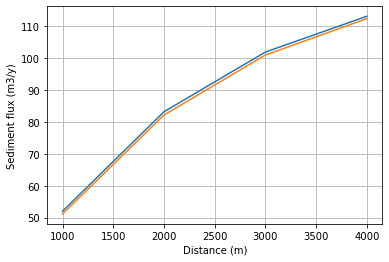

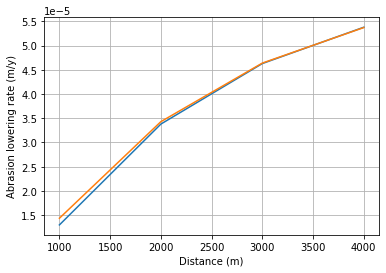

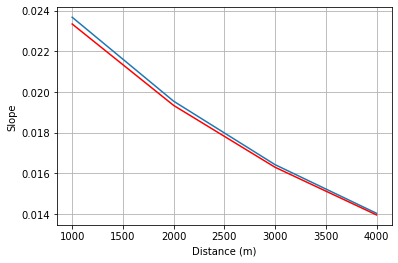

In [56]:
# Analytical solution for Qs
xan = grid.x_of_node[7:11]
Qs_analyt = (
    ((uplift_rate * dx * (1.0 - porosity)) / abrasion_coef)
    * (1.0 - np.exp(-abrasion_coef * xan)) 
)
plt.plot(xan, transporter._sediment_outflux[7:11])
plt.plot(xan, Qs_analyt)
plt.xlabel('Distance (m)')
plt.ylabel('Sediment flux (m3/y)')
plt.grid(True)

# Analytical solution for abrasion rate
Qs_analyt_nodes = (
    ((uplift_rate * dx * (1.0 - porosity)) / abrasion_coef)
    * (1.0 - np.exp(-abrasion_coef * (xan - 0.5 * dx))) 
)
abra = abrasion_coef * Qs_analyt_nodes / dx
plt.figure()
plt.plot(xan, transporter._abrasion[7:11])
plt.plot(xan, abra)
plt.xlabel('Distance (m)')
plt.ylabel('Abrasion lowering rate (m/y)')
plt.grid(True)

# Analytical solution for slope
plt.figure()
plt.plot(grid.x_of_node[7:11], transporter._slope[7:11])
Spred = (
    (((poro_fac * uplift_rate) 
     / (0.041 * 0.01 * bankfull_runoff_rate * xan * abrasion_coef)) 
    * (1.0 - np.exp(-abrasion_coef * xan)))**(6./7.)
)
plt.plot(xan, Spred, 'r')
plt.xlabel('Distance (m)')
plt.ylabel('Slope')
plt.grid(True)


## Playing with bigger scale

The below erodes an uplifted block.

In [238]:
# Parameters
dx = 1000.0
nrows = 41
ncols = 51
init_elev_plateau = 100.0
noise_amp = 1.0
abra_coef = 1.0 / 5000.0  # abrasion coefficient, 1/m
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
nsteps = 100000
dt = 0.05  # time step, y

In [239]:
# Grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=dx)
grid.status_at_node[grid.nodes_at_top_edge] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[grid.nodes_at_left_edge] = grid.BC_NODE_IS_CLOSED
elev = grid.add_zeros("topographic__elevation", at="node")
elev[grid.core_nodes] += noise_amp * np.random.rand(grid.number_of_core_nodes)
elev[grid.x_of_node <= dx * ncols//2] += init_elev_plateau
elev[grid.y_of_node > dx * nrows//2] += 0.5 * init_elev_plateau
init_elev = elev.copy()

In [240]:
# Components
fa = FlowAccumulator(
    grid,
    runoff_rate=bf_runoff_rate,
    flow_director='FlowDirectorD8',
)
transporter = GravelRiverTransporter(
    grid,
    abrasion_coefficient=abra_coef,
)

In [241]:
# Loop
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)

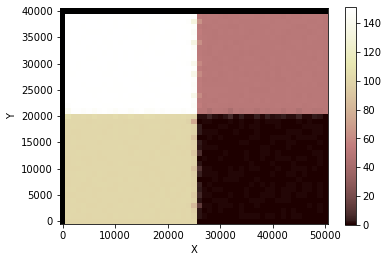

In [242]:
# Plot
imshow_grid(grid, elev)

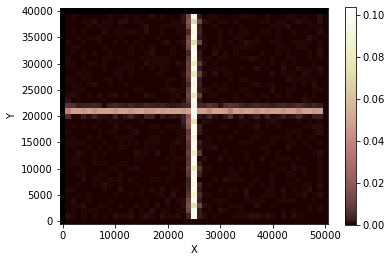

In [243]:
imshow_grid(grid, transporter._slope)

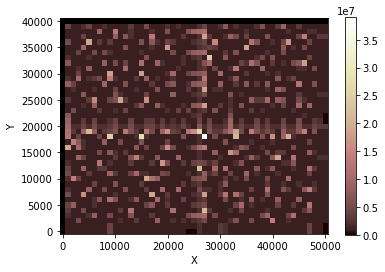

In [244]:
imshow_grid(grid, grid.at_node["drainage_area"])

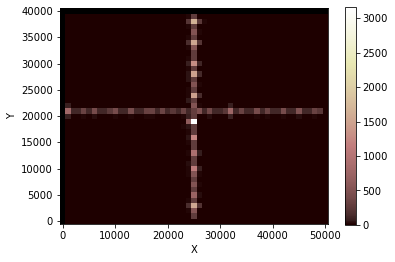

In [245]:
imshow_grid(grid, transporter._sediment_outflux)

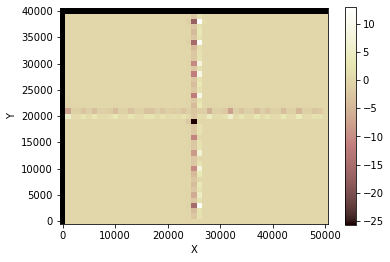

In [246]:
imshow_grid(grid, elev - init_elev)

#### Explicit time-step limits

This is a quasi-diffusive problem with a flux proportional to $k_Q I Q$. Suppose the maximum discharge is runoff rate times domain area. Then the CFL would seem to be:

$$\Delta t \lt \frac{\Delta x^2}{2 k_Q I r a_d}$$

where $a_d$ is domain area. Here's a calculation for this domain:

In [247]:
dtmax = 1.0 / (2 * 0.041 * 0.01 * 10.0 * nrows * ncols)
print(dtmax)

0.05832196055102587


This tiny value implies the need for better solvers!

In [248]:
# Continue loop
for _ in range(nsteps):
    fa.run_one_step()
    transporter.run_one_step(dt)

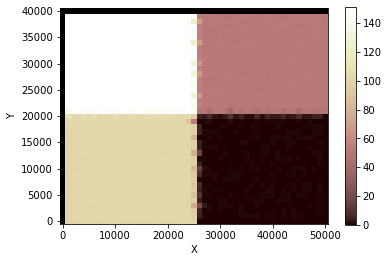

In [249]:
imshow_grid(grid, elev)

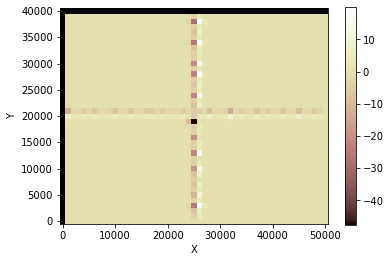

In [250]:
imshow_grid(grid, elev - init_elev)